In [1]:
import os 
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_data(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data.Group == 'AD') | (data.Group == 'CN'))]
    return data


In [3]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [4]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data(path)
y_data.head()


,Rooster ID,Group
Subject ID,,
002_S_0295,295,CN
002_S_0413,413,CN
002_S_0559,559,CN
002_S_0619,619,AD
002_S_0685,685,CN


# Data preparation & splitting 

In [5]:
from tensorflow.keras.utils import to_categorical


def Data_preparation(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            
            # hippocampe n°1 :
            
            hipp1 = img_n_mmni[40:80,90:130,40:80]
            X_data.append(hipp1)
            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)
            
            
            # hippocampe n°2 :
            
            hipp2 = img_n_mmni[100:140,90:130,40:80]
            X_data.append(hipp2)
            if Y['Group'][index] == 'AD':
                Y_data.append(1)
            elif Y['Group'][index] == 'CN':
                Y_data.append(0)    
            
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data





2022-12-09 16:14:38.924472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 16:14:39.836209: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-09 16:14:39.836278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/coleger/miniconda3/envs/tf/lib/
2022-12-09 16:14:39.836284: W tensorflow/compiler/tf

In [6]:
X_data, Y_data = Data_preparation(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(838, 40, 40, 40)
838


In [7]:
print(X_data[0].shape)
print(X_data[1].shape)



(40, 40, 40)
(40, 40, 40)


In [8]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=49) 

print("Data splited, length of training data is: ", len(X_train))
print("Data splited, length of test data is: ", len(X_test))

Data splited, length of training data is:  670
Data splited, length of test data is:  168


# Creation and evaluation of Conv3D model

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

model = Sequential()
# Couches de convolution + MaxPooling
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(40,40,40,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.3))
# Couches de classification
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

    

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 38, 38, 38, 32)    896       
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 19, 19, 19, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 19, 19, 19, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 19, 19, 19, 32)    0         
                                                                 
 conv3d_13 (Conv3D)          (None, 17, 17, 17, 64)    55360     
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 8, 8, 8, 64)     

# Training and evaluation with 80% of CN et AD data 

In [24]:
import tensorflow as tf
# ajout d'un early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[callback],batch_size=32)

Epoch 1/100
21/21 [==============================] - 3s 95ms/step - loss: 0.7116 - accuracy: 0.6791 - val_loss: 40.5280 - val_accuracy: 0.4524
Epoch 2/100
21/21 [==============================] - 1s 59ms/step - loss: 0.5633 - accuracy: 0.7552 - val_loss: 13.5863 - val_accuracy: 0.4524
Epoch 3/100
21/21 [==============================] - 1s 59ms/step - loss: 0.4288 - accuracy: 0.8209 - val_loss: 6.8941 - val_accuracy: 0.4524
Epoch 4/100
21/21 [==============================] - 1s 59ms/step - loss: 0.3737 - accuracy: 0.8269 - val_loss: 4.5312 - val_accuracy: 0.4524
Epoch 5/100
21/21 [==============================] - 1s 59ms/step - loss: 0.4148 - accuracy: 0.8239 - val_loss: 3.5550 - val_accuracy: 0.4524
Epoch 6/100
21/21 [==============================] - 1s 60ms/step - loss: 0.3467 - accuracy: 0.8433 - val_loss: 0.4329 - val_accuracy: 0.7857
Epoch 7/100
21/21 [==============================] - 1s 60ms/step - loss: 0.2984 - accuracy: 0.8701 - val_loss: 0.4658 - val_accuracy: 0.7917
Epoc

# Plotting metrics 

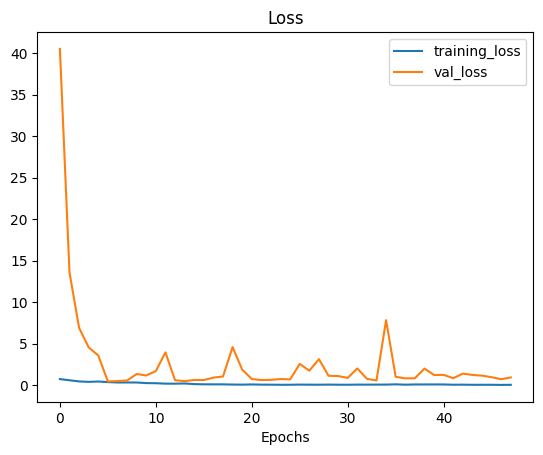

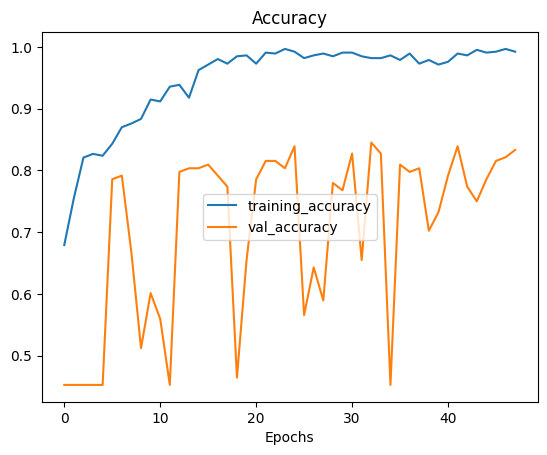

In [25]:
def plot_loss_curves(history):
    
      
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

plot_loss_curves(history)

In [26]:
best_val_accuracy = np.max(history.history['val_accuracy'])
print(' Best val_accuracy value : {} '.format(best_val_accuracy))

 Best val_accuracy value : 0.8452380895614624 


# Training with whole AD and CN data

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

model2 = Sequential()
# Couches de convolution + MaxPooling
model2.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(40,40,40,1)))
# input shape = (batch_size, channels, dim1, dim2,dim3)
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
model2.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
model2.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(BatchNormalization(center=True, scale=True))
model2.add(Dropout(0.3))
# Couches de classification
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model2.summary()

    

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 38, 38, 38, 32)    896       
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 19, 19, 19, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 19, 19, 19, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 19, 19, 19, 32)    0         
                                                                 
 conv3d_16 (Conv3D)          (None, 17, 17, 17, 64)    55360     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 8, 8, 8, 64)     

In [28]:
history2 = model2.fit(X_data, y_data, epochs=20)

Epoch 1/20
27/27 [==============================] - 2s 52ms/step - loss: 0.7069 - accuracy: 0.7005
Epoch 2/20
27/27 [==============================] - 1s 52ms/step - loss: 0.5358 - accuracy: 0.7554
Epoch 3/20
27/27 [==============================] - 1s 52ms/step - loss: 0.4675 - accuracy: 0.7983
Epoch 4/20
27/27 [==============================] - 1s 52ms/step - loss: 0.4507 - accuracy: 0.8055
Epoch 5/20
27/27 [==============================] - 1s 52ms/step - loss: 0.3894 - accuracy: 0.8305
Epoch 6/20
27/27 [==============================] - 1s 52ms/step - loss: 0.3748 - accuracy: 0.8520
Epoch 7/20
27/27 [==============================] - 1s 52ms/step - loss: 0.3403 - accuracy: 0.8532
Epoch 8/20
27/27 [==============================] - 1s 52ms/step - loss: 0.2893 - accuracy: 0.8807
Epoch 9/20
27/27 [==============================] - 1s 52ms/step - loss: 0.2948 - accuracy: 0.8890
Epoch 10/20
27/27 [==============================] - 1s 52ms/step - loss: 0.2244 - accuracy: 0.9045
Epoch 11/

# Testing with pMCI et sMCI data 

- pMCI ~ AD ==1
- sMCI ~ CN ==0

In [31]:
def get_data_MCI(path):
    data = pd.read_csv(path, names= ['Subject ID', 'Rooster ID', 'Age', 'Sexe', 'Group', 'Conversion', 'MMSE', 'RAVLT', 'FAQ', 'CDR-SB', 'ADAS11'], usecols = ['Subject ID', 'Rooster ID', 'Group','Conversion'])
    data.index = data['Subject ID']
    data = data.drop(['Subject ID'], axis=1)
    data = data[((data['Conversion'] == 1) | (data['Conversion'] == 2) | (data['Conversion'] == 3) | (data['Conversion'] == 4))]
    return data


In [32]:
path = str(Path().resolve())
path = path + "/ADNI1/"
filename = os.listdir(path)[2]
n_mmni_filename = os.path.join(path, filename)
img_n_mmni = nib.load(n_mmni_filename)


In [33]:
path = str(Path().resolve()) + "/ADNI1/list_standardized_tongtong_2017.csv"
y_data = get_data_MCI(path)
y_data.head()


,Rooster ID,Group,Conversion
Subject ID,,,
002_S_0729,729,MCI,3
002_S_0782,782,MCI,4
002_S_0954,954,MCI,3
002_S_1070,1070,MCI,3
002_S_1155,1155,MCI,4


# Data preparation & splitting 

In [34]:
from tensorflow.keras.utils import to_categorical


def Data_preparation_MCI(Y):
    X_data = []
    Y_data = []
    
    path = str(Path().resolve()) + "/ADNI1"
    for index, _ in Y.iterrows():
        filename = path + '/n_mmni_fADNI_' + index + '_1.5T_t1w.nii.gz'
        
        if os.path.isfile(filename):
            img_n_mmni = nib.load(filename).get_fdata()
            
            # hippocampe n°1 :
            
            hipp1 = img_n_mmni[40:80,90:130,40:80]
            X_data.append(hipp1)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)
            
            
            # hippocampe n°2 :
            
            hipp2 = img_n_mmni[100:140,90:130,40:80]
            X_data.append(hipp2)
            if Y['Conversion'][index] == 1 | Y['Conversion'][index] == 2 | Y['Conversion'][index] == 3 : # pMCI
                Y_data.append(1)
            elif Y['Conversion'][index] == 4 : #sMCI
                Y_data.append(0)    
            1
        else:
            Y.drop(index, inplace=True)
        
    X_data = np.array(X_data)   
    return X_data, Y_data





In [35]:
X_data, Y_data = Data_preparation_MCI(y_data)
Y_data = to_categorical(Y_data, num_classes=2)

print(X_data.shape)
print(len(Y_data))

(600, 40, 40, 40)
600


In [36]:
# on garde seulement une colonne pour y 
y_data = np.argmax(Y_data, axis= 1)

## Prédiction (pour chaque hippocampe) 

In [37]:
ypred_raw_model1 = model.predict(X_data)
ypred_raw_model2 = model2.predict(X_data)

19/19 [==============================] - 0s 17ms/step


In [38]:
ypred_model1 = np.where(ypred_raw_model1 > 0.5, 1, 0)
ypred_model2 = np.where(ypred_raw_model2 > 0.5, 1, 0)

In [39]:
from sklearn.metrics import accuracy_score

acc_model1 = accuracy_score(ypred_model1, y_data)
acc_model2 = accuracy_score(ypred_model2, y_data)

print('accuracy on MCI data based on CN and AD training with model 1: {} '.format(acc_model1))
print('accuracy on MCI data based on CN and AD training with model 2: {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training with model 1: 0.61 
accuracy on MCI data based on CN and AD training with model 2: 0.665 


## Prédiction (pour chaque hippocampe) 

Comme on ajoute à chaque fois les deux hippocampes du même sujet à la suite, les labels sont les mêmes pour toutes les paires de données et on en prend que 1 sur 2

In [42]:
y_real_data = y_data[::2]
print(y_real_data.shape)

(300,)


Pour la prédiction pour un patient, on prend la moyenne issue de l'activation sigmoid du réseau de neurones pour les deux hippocampes 

In [40]:
y_pred_hipp1_model1 = ypred_raw_model1[::2]
y_pred_hipp2_model1 =  ypred_raw_model1[1::2]
y_real_pred_raw_model1 = (y_pred_hipp1_model1 + y_pred_hipp2_model1)/2
y_real_pred_model1 = np.where(y_real_pred_raw_model1 > 0.5, 1,0)

y_pred_hipp1_model2 = ypred_raw_model2[::2]
y_pred_hipp2_model2 =  ypred_raw_model2[1::2]
y_real_pred_raw_model2 = (y_pred_hipp1_model2 + y_pred_hipp2_model2)/2
y_real_pred_model2 = np.where(y_real_pred_raw_model2 > 0.5, 1,0)

In [43]:
acc_model1 = accuracy_score(y_real_pred_model1, y_real_data)
acc_model2 = accuracy_score(y_real_pred_model2, y_real_data)

print('accuracy on MCI data based on CN and AD training with model 1 : {} '.format(acc_model1))
print('accuracy on MCI data based on CN and AD training with model 2 : {} '.format(acc_model2))

accuracy on MCI data based on CN and AD training with model 1 : 0.6533333333333333 
accuracy on MCI data based on CN and AD training with model 2 : 0.7 


On garde la meilleure prédiction pour afficher la matrice de confusion

[[ 77  52]
 [ 38 133]]


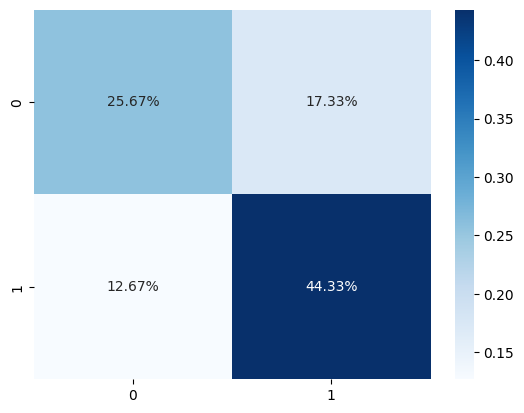

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

names = ['sMCI','pMCI']

cf_matrix = confusion_matrix(y_real_data, y_real_pred_model2)
print(cf_matrix)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

- pMCI ~ AD ==1
- sMCI ~ CN ==0